In [46]:
# To have reproducible results and compare them
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

In [47]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [48]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [49]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
print(old_train.shape)

(3662, 2)
(35126, 2)


In [50]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

# path columns
new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

,id_code,diagnosis
0,../input/diabetic-retinopathy-resized/resized_...,0
1,../input/diabetic-retinopathy-resized/resized_...,0
2,../input/diabetic-retinopathy-resized/resized_...,0
3,../input/diabetic-retinopathy-resized/resized_...,0
4,../input/diabetic-retinopathy-resized/resized_...,1


## Train - Valid split

In [51]:
# Not used in version 5
train_df, val_df = train_test_split(train_df, shuffle=True, stratify=train_df.diagnosis, test_size=0.1, random_state=2019)

In [52]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(31613, 2)
(3513, 2)


### Process Images

In [53]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

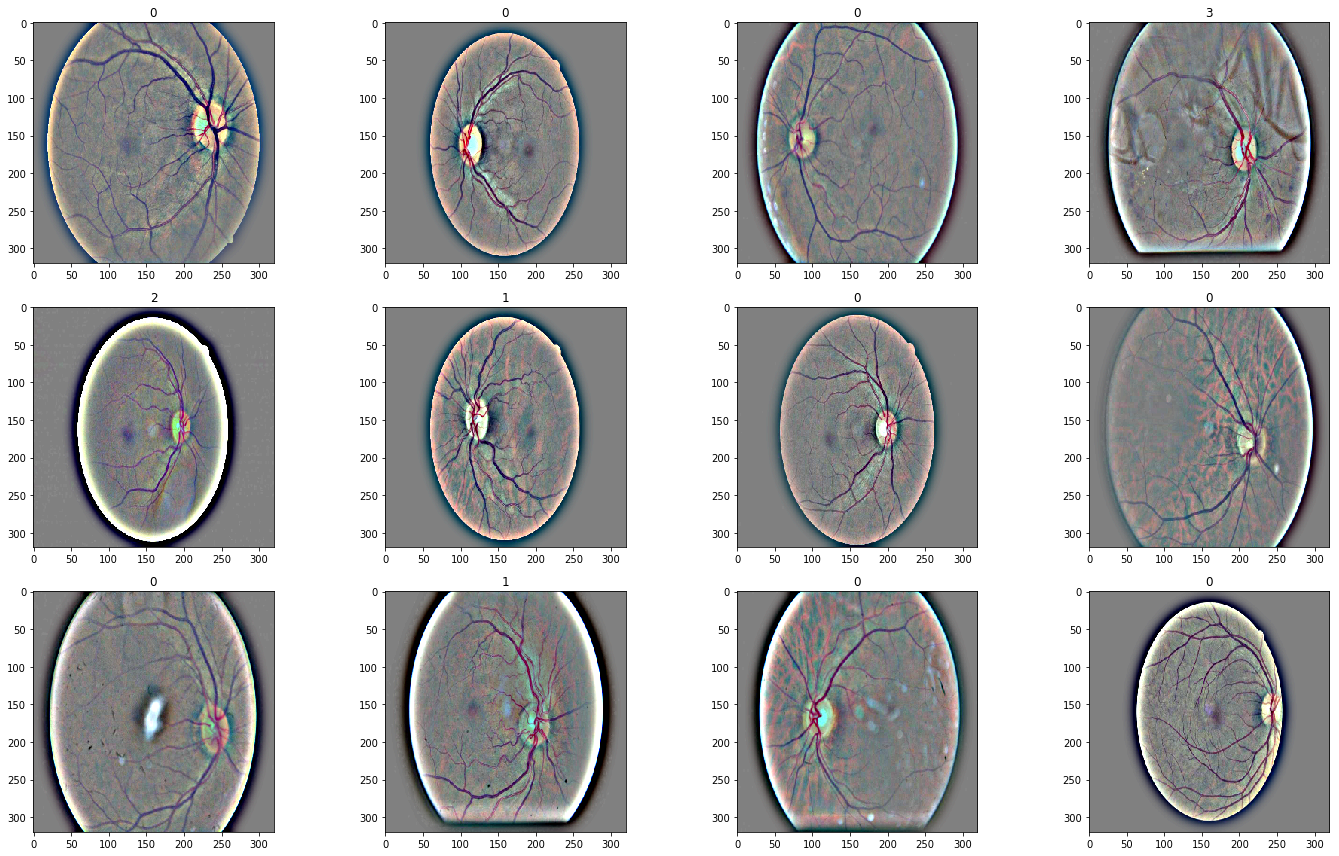

In [54]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

In [55]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

  0%|          | 0/3513 [00:00<?, ?it/s]

In [56]:
y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(31613, 5)
(3513, 320, 320, 3)
(3513, 5)


In [57]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (31613, 5)
Y_val multi: (3513, 5)


In [58]:
y_train = y_train_multi
y_val = y_val_multi

In [59]:
# delete the uneeded df
del new_train
del old_train
del val_df
gc.collect()

27523

# Creating keras callback for QWK

In [60]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [61]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [62]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

In [63]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [64]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [65]:
train_df = train_df.reset_index(drop=True)
bucket_num = 8
div = round(train_df.shape[0]/bucket_num)

In [66]:
df_init = {
    'val_loss': [0.0],
    'val_acc': [0.0],
    'loss': [0.0], 
    'acc': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [67]:
epochs = [5,5,10,15,15,20,20,30]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [68]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0


  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/5
124/123 [==============================] - 139s 1s/step - loss: 0.3652 - acc: 0.8424 - val_loss: 0.2443 - val_acc: 0.9069
val_kappa: 0.3116
Validation Kappa has improved. Saving model.
Epoch 2/5
124/123 [==============================] - 100s 808ms/step - loss: 0.2368 - acc: 0.9065 - val_loss: 0.2410 - val_acc: 0.9159
val_kappa: 0.4389
Validation Kappa has improved. Saving model.
Epoch 3/5
124/123 [==============================] - 101s 813ms/step - loss: 0.2105 - acc: 0.9180 - val_loss: 0.2819 - val_acc: 0.9163
val_kappa: 0.4232
Epoch 4/5
124/123 [==============================] - 101s 811ms/step - loss: 0.1961 - acc: 0.9216 - val_loss: 0.3033 - val_acc: 0.9163
val_kappa: 0.3853
Epoch 5/5
124/123 [==============================] - 100s 809ms/step - loss: 0.1823 - acc: 0.9296 - val_loss: 0.2174 - val_acc: 0.9266
val_kappa: 0.5676
Validation Kappa has improved. Saving model.
----------------------------------------
Bucket Nr: 1


  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/5
124/123 [==============================] - 106s 857ms/step - loss: 0.2000 - acc: 0.9219 - val_loss: 0.2158 - val_acc: 0.9257
val_kappa: 0.5102
Epoch 2/5
124/123 [==============================] - 100s 805ms/step - loss: 0.1873 - acc: 0.9267 - val_loss: 0.3140 - val_acc: 0.9172
val_kappa: 0.3831
Epoch 3/5
124/123 [==============================] - 100s 808ms/step - loss: 0.1802 - acc: 0.9296 - val_loss: 0.3113 - val_acc: 0.9160
val_kappa: 0.3667
Epoch 4/5
124/123 [==============================] - 100s 807ms/step - loss: 0.1778 - acc: 0.9302 - val_loss: 0.1839 - val_acc: 0.9287
val_kappa: 0.6436
Validation Kappa has improved. Saving model.
Epoch 5/5
124/123 [==============================] - 100s 807ms/step - loss: 0.1696 - acc: 0.9320 - val_loss: 0.2080 - val_acc: 0.9186
val_kappa: 0.6016
----------------------------------------
Bucket Nr: 2


  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/10
124/123 [==============================] - 107s 859ms/step - loss: 0.1852 - acc: 0.9282 - val_loss: 0.2422 - val_acc: 0.9245
val_kappa: 0.4817
Epoch 2/10
124/123 [==============================] - 100s 805ms/step - loss: 0.1780 - acc: 0.9313 - val_loss: 0.2319 - val_acc: 0.9264
val_kappa: 0.5517
Epoch 3/10
124/123 [==============================] - 100s 807ms/step - loss: 0.1699 - acc: 0.9340 - val_loss: 0.2414 - val_acc: 0.9268
val_kappa: 0.5324
Epoch 4/10
124/123 [==============================] - 100s 808ms/step - loss: 0.1611 - acc: 0.9385 - val_loss: 0.2623 - val_acc: 0.9280
val_kappa: 0.5239
Epoch 5/10
124/123 [==============================] - 100s 804ms/step - loss: 0.1562 - acc: 0.9403 - val_loss: 0.2716 - val_acc: 0.9263
val_kappa: 0.5568
Epoch 6/10
124/123 [==============================] - 99s 802ms/step - loss: 0.1539 - acc: 0.9412 - val_loss: 0.3013 - val_acc: 0.9214
val_kappa: 0.4513
Epoch 7/10
124/123 [==============================] - 99s 802ms/step - loss: 

  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/15
124/123 [==============================] - 106s 851ms/step - loss: 0.1778 - acc: 0.9329 - val_loss: 0.2249 - val_acc: 0.9319
val_kappa: 0.5745
Epoch 2/15
124/123 [==============================] - 99s 800ms/step - loss: 0.1647 - acc: 0.9358 - val_loss: 0.2214 - val_acc: 0.9310
val_kappa: 0.5619
Epoch 3/15
124/123 [==============================] - 100s 804ms/step - loss: 0.1574 - acc: 0.9405 - val_loss: 0.1806 - val_acc: 0.9364
val_kappa: 0.6233
Epoch 4/15
124/123 [==============================] - 99s 800ms/step - loss: 0.1523 - acc: 0.9431 - val_loss: 0.3013 - val_acc: 0.9194
val_kappa: 0.4217
Epoch 5/15
124/123 [==============================] - 99s 799ms/step - loss: 0.1450 - acc: 0.9456 - val_loss: 0.2031 - val_acc: 0.9322
val_kappa: 0.5870
Epoch 6/15
124/123 [==============================] - 99s 800ms/step - loss: 0.1446 - acc: 0.9449 - val_loss: 0.2246 - val_acc: 0.9304
val_kappa: 0.5989
Epoch 7/15
124/123 [==============================] - 101s 818ms/step - loss: 0.

  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/15
124/123 [==============================] - 106s 851ms/step - loss: 0.1785 - acc: 0.9338 - val_loss: 0.2254 - val_acc: 0.9363
val_kappa: 0.6445
Epoch 2/15
124/123 [==============================] - 99s 798ms/step - loss: 0.1538 - acc: 0.9419 - val_loss: 0.1764 - val_acc: 0.9358
val_kappa: 0.6617
Epoch 3/15
124/123 [==============================] - 99s 800ms/step - loss: 0.1478 - acc: 0.9428 - val_loss: 0.1992 - val_acc: 0.9312
val_kappa: 0.6233
Epoch 4/15
124/123 [==============================] - 99s 802ms/step - loss: 0.1395 - acc: 0.9456 - val_loss: 0.2764 - val_acc: 0.9299
val_kappa: 0.5500
Epoch 5/15
124/123 [==============================] - 99s 799ms/step - loss: 0.1360 - acc: 0.9477 - val_loss: 0.2206 - val_acc: 0.9336
val_kappa: 0.6106
Epoch 6/15
124/123 [==============================] - 99s 798ms/step - loss: 0.1330 - acc: 0.9488 - val_loss: 0.3770 - val_acc: 0.9220
val_kappa: 0.4707
Epoch 7/15
124/123 [==============================] - 99s 798ms/step - loss: 0.12

  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/20
124/123 [==============================] - 105s 849ms/step - loss: 0.1696 - acc: 0.9373 - val_loss: 0.1947 - val_acc: 0.9394
val_kappa: 0.6815
Epoch 2/20
124/123 [==============================] - 99s 799ms/step - loss: 0.1511 - acc: 0.9429 - val_loss: 0.1859 - val_acc: 0.9401
val_kappa: 0.6662
Epoch 3/20
124/123 [==============================] - 100s 803ms/step - loss: 0.1424 - acc: 0.9451 - val_loss: 0.2482 - val_acc: 0.9325
val_kappa: 0.5626
Epoch 4/20
124/123 [==============================] - 99s 800ms/step - loss: 0.1337 - acc: 0.9487 - val_loss: 0.2229 - val_acc: 0.9356
val_kappa: 0.6172
Epoch 5/20
124/123 [==============================] - 99s 801ms/step - loss: 0.1281 - acc: 0.9510 - val_loss: 0.2447 - val_acc: 0.9295
val_kappa: 0.5340
Epoch 6/20
124/123 [==============================] - 99s 798ms/step - loss: 0.1243 - acc: 0.9514 - val_loss: 0.3020 - val_acc: 0.9311
val_kappa: 0.5510
Epoch 7/20
124/123 [==============================] - 99s 799ms/step - loss: 0.1

  0%|          | 0/3952 [00:00<?, ?it/s]

Epoch 1/20
124/123 [==============================] - 106s 855ms/step - loss: 0.1716 - acc: 0.9381 - val_loss: 0.2228 - val_acc: 0.9164
val_kappa: 0.6244
Epoch 2/20
124/123 [==============================] - 100s 803ms/step - loss: 0.1373 - acc: 0.9493 - val_loss: 0.1656 - val_acc: 0.9417
val_kappa: 0.6954
Validation Kappa has improved. Saving model.
Epoch 3/20
124/123 [==============================] - 99s 802ms/step - loss: 0.1312 - acc: 0.9484 - val_loss: 0.1581 - val_acc: 0.9441
val_kappa: 0.7173
Validation Kappa has improved. Saving model.
Epoch 4/20
124/123 [==============================] - 100s 803ms/step - loss: 0.1282 - acc: 0.9500 - val_loss: 0.2437 - val_acc: 0.9231
val_kappa: 0.5789
Epoch 5/20
124/123 [==============================] - 100s 803ms/step - loss: 0.1218 - acc: 0.9524 - val_loss: 0.2528 - val_acc: 0.9349
val_kappa: 0.6112
Epoch 6/20
124/123 [==============================] - 99s 801ms/step - loss: 0.1151 - acc: 0.9560 - val_loss: 0.2436 - val_acc: 0.9287
val_ka

  0%|          | 0/3949 [00:00<?, ?it/s]

Epoch 1/30
124/123 [==============================] - 109s 878ms/step - loss: 0.1761 - acc: 0.9385 - val_loss: 0.7680 - val_acc: 0.8648
val_kappa: 0.4560
Epoch 2/30
124/123 [==============================] - 100s 807ms/step - loss: 0.1427 - acc: 0.9453 - val_loss: 0.2066 - val_acc: 0.9289
val_kappa: 0.6018
Epoch 3/30
124/123 [==============================] - 100s 808ms/step - loss: 0.1290 - acc: 0.9528 - val_loss: 0.1959 - val_acc: 0.9403
val_kappa: 0.6762
Epoch 4/30
124/123 [==============================] - 101s 811ms/step - loss: 0.1234 - acc: 0.9529 - val_loss: 0.4107 - val_acc: 0.9217
val_kappa: 0.4435
Epoch 5/30
124/123 [==============================] - 100s 809ms/step - loss: 0.1172 - acc: 0.9535 - val_loss: 0.2949 - val_acc: 0.9251
val_kappa: 0.5097
Epoch 6/30
124/123 [==============================] - 100s 805ms/step - loss: 0.1129 - acc: 0.9557 - val_loss: 0.2678 - val_acc: 0.9221
val_kappa: 0.5299
Epoch 7/30
124/123 [==============================] - 101s 811ms/step - loss

# Find best threshold

In [70]:
model.save('CEDT_Model.h5')
print("Model saved successfully!")

# โหลดโมเดล
# from tensorflow.keras.models import load_model
# model = load_model('CEDT_Model.h5')

# คำนวณ QWK score และ optimize threshold
from sklearn.metrics import cohen_kappa_score
import scipy.optimize

y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = (y_val_pred > threshold).astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 
    x0=0.5, 
    method='nelder-mead'
)

best_threshold = simplex.x[0]

# คำนวณผลลัพธ์ด้วย threshold ที่ดีที่สุด
y1_best = (y_val_pred > best_threshold).astype(int).sum(axis=1) - 1
y1_default = (y_val_pred > 0.5).astype(int).sum(axis=1) - 1
y2_true = y_val.sum(axis=1) - 1

score_best = cohen_kappa_score(y1_best, y2_true, weights='quadratic')
score_default = cohen_kappa_score(y1_default, y2_true, weights='quadratic')

print(f'Threshold ที่ดีที่สุด: {best_threshold:.4f}')
print(f'Validation QWK score (threshold ที่ดีที่สุด): {score_best:.4f}')
print(f'Validation QWK score (threshold 0.5): {score_default:.4f}')

Model saved successfully!
Threshold ที่ดีที่สุด: 0.0062
Validation QWK score (threshold ที่ดีที่สุด): 0.5753
Validation QWK score (threshold 0.5): 0.4850
